In [2]:
import csv
import gzip
import os
import matplotlib
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, AffinityPropagation, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
matrix_dir = "genesrna"
mat = pd.read_csv("genesrna/rnamat.csv")
datafile = 'dataset2.count.txt'
df = pd.read_csv(datafile, sep='\t')
df = df.set_index('Gene.Symbol')
cells = list(df.columns.values)
mat = np.array(mat)
features_path = os.path.join(matrix_dir, "features.txt")
annotation  = pd.read_csv(features_path,sep='\t',header=None)
annotation.columns = ['gene_names']
barcodes_path = os.path.join(matrix_dir, "barcodes.txt")
barcodes = [line.strip() for line in open(barcodes_path, 'r')]
mat = mat.T 
print('compiled!')
mat.shape

compiled!


(626, 22241)

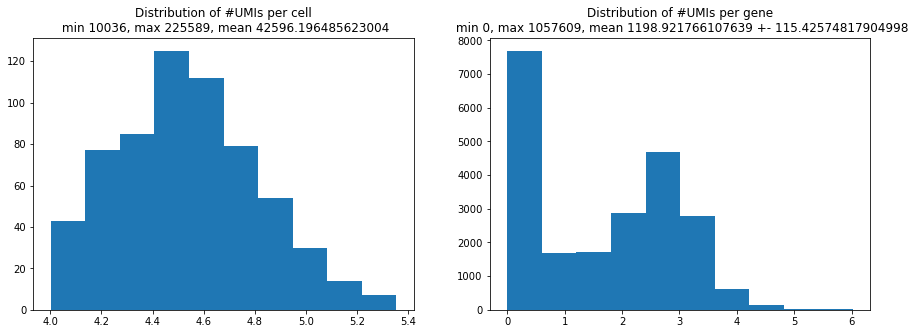

In [4]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis=1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))));

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1));
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +- {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))));
plt.show()

Text(0.5, 1.0, 'Distribution of CV, mean 1.4662495368124753 sd 1.0003227369510244')

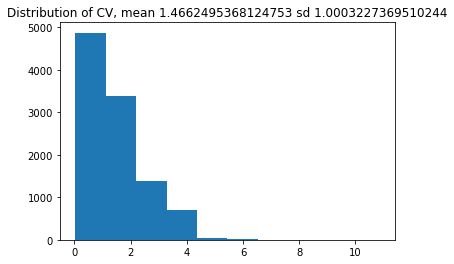

In [5]:
low_expr_thr = 100
high_expr_thr = 1000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
plt.hist(CV)
plt.title('Distribution of CV, mean {} sd {}'.format(np.mean(CV), np.std(CV)**0.5))

(626, 3951)


Text(0.5, 1.0, 'Distribution of #UMIs per gene\n min 100, max 2601, mean 257.64464692482915 +1 11.208466954917885')

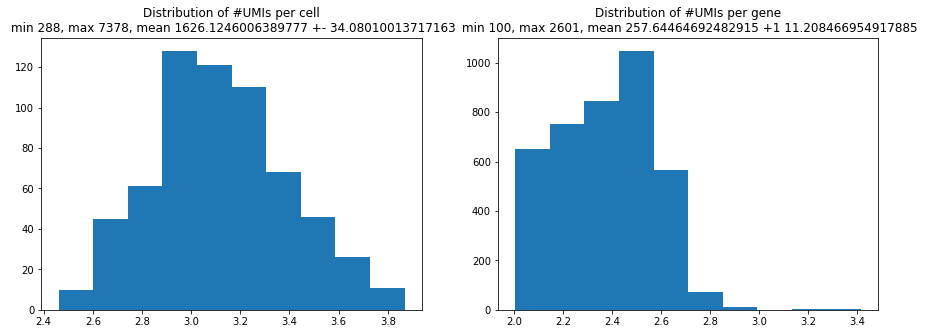

In [6]:
mat = mat[:, CV >= 1.5]
print(mat.shape)
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis = 1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {} +- {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))))

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1))
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +1 {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))))

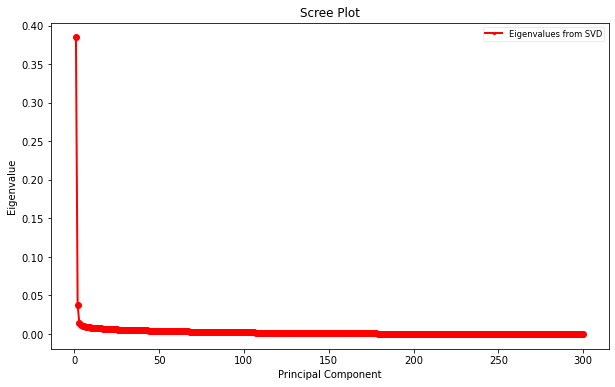

In [7]:
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)
test = mat[:300, :300]
U, S, V = np.linalg.svd(test) 
eigvals = S**2 / np.sum(S**2)  # NOTE (@amoeba): These are not PCA eigenvalues. 
                               # This question is about SVD.

fig = plt.figure(figsize=(10, 6))
sing_vals = np.arange(len(test)) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
fig.savefig('Zoomed in Scree Plot.png')
#leg.draggable(state=True)

626


Text(0.5, 1.0, 'Naive Clustering')

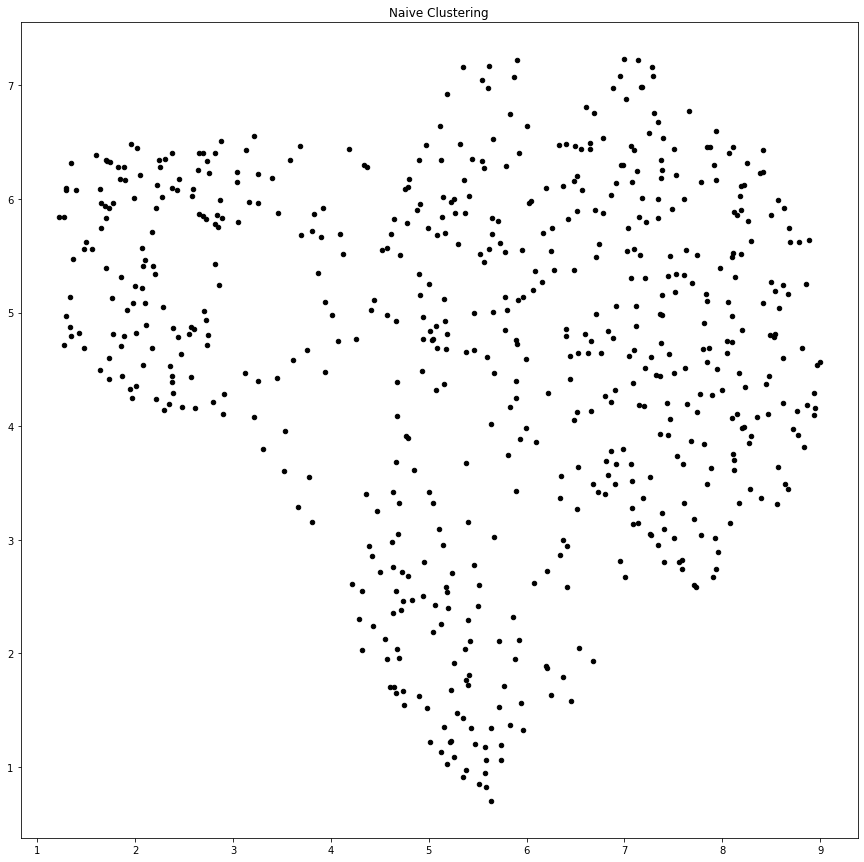

In [8]:
pca = PCA(n_components=100)
pca.fit(mat)
mat_reduce=pca.transform(mat)
true_indices = {}
true_coords = {}
with open('mat_reduce.txt', 'w') as f:
    for i in mat_reduce:
        f.write("%s\n" % i)
embedding = umap.UMAP(n_neighbors=10, min_dist=0.2, metric='euclidean').fit_transform(mat_reduce)
print(len(embedding))
for i in range (0, len(embedding)):
    true_indices.update({str(embedding[i]):cells[i]})
    true_coords.update({cells[i]:str(embedding[i]).strip()})
with open('embedding.txt', 'w') as f:
    for e in embedding:
        f.write("%s\n" % e)
plt.figure(figsize=(15, 15))
plt.scatter(embedding[:,0],embedding[:,1], s=20.0, color='black')
plt.title('Naive Clustering')

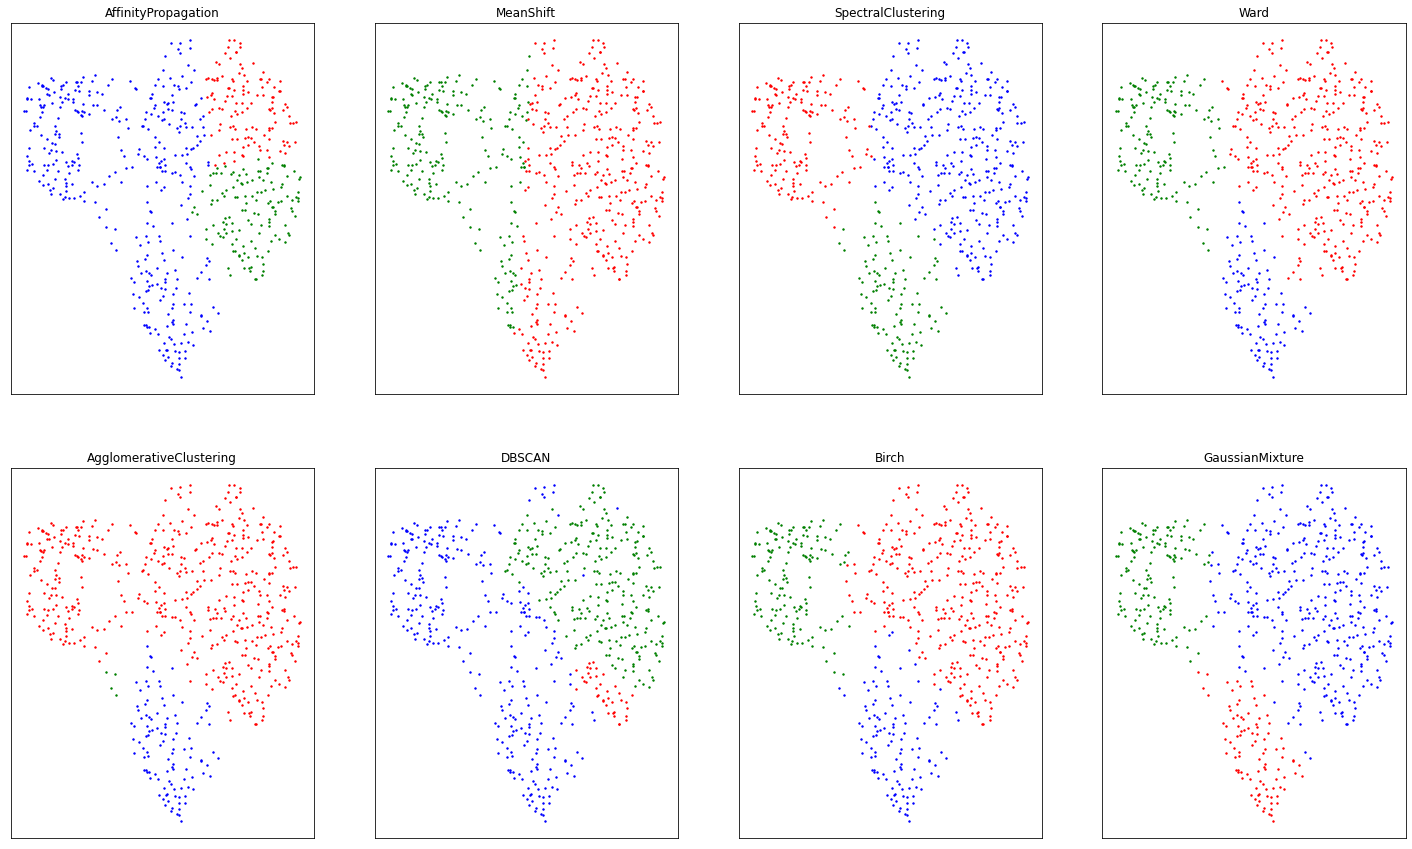

In [9]:
params = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference':-200, 'n_neighbors':10, 'n_clusters':3}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
clustering_algorithms = (
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm))
#now plot everything
f, ax = plt.subplots(2, 4, figsize=(25,15))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['black', 'red', 'green']),
                                    int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    
    colors = np.append(colors, ["#000000"])
    for i in range(len(embedding)):
        if y_pred[i] == 0:
            color = 'red'
        elif y_pred[i] == 1:
            color = 'green'
        else: 
            color = 'blue'
        ax[idx//4, idx%4].scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=2, color=color)
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//4, idx%4].set_xticks(())
    ax[idx//4, idx%4].set_yticks(())
    ax[idx//4, idx%4].set_title(name)
    #Store the labels
    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    #print(labels)
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])
   # print('{}'.format(name))
   # print(counts)
    #print(embedding)
plt.savefig('All Clusters.png')

{'C_L_BREAST_AAGACTCGTGGTACAG': 0, 'C_L_BREAST_ACTGATGGTCAGGTGA': 2, 'C_L_BREAST_ATGAGGGAGCTTAAGA': 0, 'C_L_BREAST_CCGGACACAAGACAAT': 1, 'C_L_BREAST_CTGCCATCACAATGCT': 1, 'C_L_BREAST_TAAGTCGCACCTCGTT': 0, 'C_L_BREAST_TCCATCGGTGCTCGTG': 0, 'P_SKIN_AAAGAACGTAACAGTA': 0, 'P_SKIN_AAATGGAGTATGTCCA': 0, 'P_SKIN_AACAAAGGTGTGTTTG': 0, 'P_SKIN_AACAACCTCTGGGCCA': 0, 'P_SKIN_AACAGGGCAAGAGGCT': 0, 'P_SKIN_AACCTTTGTCGTCATA': 1, 'P_SKIN_AACTTCTCATGTCAGT': 0, 'P_SKIN_AAGACAAAGTTTCTTC': 1, 'P_SKIN_AAGACTCCAATACCCA': 0, 'P_SKIN_AAGTACCAGGAAAGGT': 0, 'P_SKIN_AATGAAGAGCGTATGG': 0, 'P_SKIN_AATGAAGCACAAATAG': 1, 'P_SKIN_AATGAAGGTAGGACCA': 0, 'P_SKIN_AATGCCAGTTCTAACG': 0, 'P_SKIN_ACAAAGAGTTACAGCT': 0, 'P_SKIN_ACATCCCCAATTTCGG': 1, 'P_SKIN_ACCCTTGGTCTGCGCA': 0, 'P_SKIN_ACCTACCAGCAACAAT': 0, 'P_SKIN_ACCTACCCAATAAGGT': 0, 'P_SKIN_ACGATGTGTCATCGGC': 0, 'P_SKIN_ACGGTCGGTGCTCGTG': 1, 'P_SKIN_ACGTAGTAGCCGTAAG': 1, 'P_SKIN_ACTACGAAGGAACATT': 1, 'P_SKIN_ACTATTCAGATCGACG': 0, 'P_SKIN_ACTGATGGTTGAAGTA': 1, 'P_SKIN_ACT

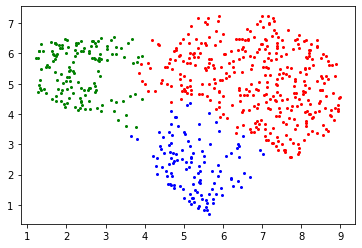

In [10]:
'''birch.fit(embedding)
birch_coords = {}
y_pred = birch.labels_.astype(np.int)
colors = np.append(colors, ["#000000"])
for i in range(len(embedding)):
    birch_coords.update({str(embedding[i]):y_pred[i]})
    if y_pred[i] == 0:
        color = 'red'
    elif y_pred[i] == 1:
        color = 'green'
    else: 
        color = 'blue'
    plt.scatter(embedding[i-1:i, 0], embedding[i-1:i, 1], s=4, color=color)
print(birch_coords)
true_labels = {}
for i in birch_coords:
    true_labels.update({true_indices[i]:birch_coords[i]})
print(true_labels)'''

def FindTrueLabels(algorithm):
    algorithm_coords = {}
    y_pred = algorithm.labels_.astype(np.int)
    for i in range(len(embedding)):
        if y_pred[i] == 0:
            color = 'red'
        elif y_pred[i] == 1:
            color = 'green'
        else: 
            color = 'blue'
        plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=color)
        algorithm_coords.update({str(embedding[i]):y_pred[i]})
        
    true_labels = {}
    for i in algorithm_coords:
        true_labels.update({true_indices[i]:algorithm_coords[i]})
    return true_labels

print(FindTrueLabels(birch))

In [11]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

In [11]:
from hashlib import sha1

from numpy import all, array, uint8


class hashable(object):
    r'''Hashable wrapper for ndarray objects.

        Instances of ndarray are not hashable, meaning they cannot be added to
        sets, nor used as keys in dictionaries. This is by design - ndarray
        objects are mutable, and therefore cannot reliably implement the
        __hash__() method.

        The hashable class allows a way around this limitation. It implements
        the required methods for hashable objects in terms of an encapsulated
        ndarray object. This can be either a copied instance (which is safer)
        or the original object (which requires the user to be careful enough
        not to modify it).
    '''
    def __init__(self, wrapped, tight=False):
        r'''Creates a new hashable object encapsulating an ndarray.

            wrapped
                The wrapped ndarray.

            tight
                Optional. If True, a copy of the input ndaray is created.
                Defaults to False.
        '''
        self.__tight = tight
        self.__wrapped = array(wrapped) if tight else wrapped
        self.__hash = int(sha1(wrapped.view(uint8)).hexdigest(), 16)

    def __eq__(self, other):
        return all(self.__wrapped == other.__wrapped)

    def __hash__(self):
        return self.__hash

    def unwrap(self):
        r'''Returns the encapsulated ndarray.

            If the wrapper is "tight", a copy of the encapsulated ndarray is
            returned. Otherwise, the encapsulated ndarray itself is returned.
        '''
        if self.__tight:
            return array(self.__wrapped)

        return self.__wrapped

1
128
157
223
223
270
482
489
623
626
623


{'[4.5750484 4.9781218]': 'pink',
 '[1.8207141 6.28548  ]': 'red',
 '[2.0657675 5.217592 ]': 'red',
 '[2.447564 6.175837]': 'red',
 '[1.4239491 4.8208227]': 'red',
 '[2.7897637 4.2109   ]': 'red',
 '[2.012049  4.3506193]': 'red',
 '[2.224335  6.1248903]': 'red',
 '[1.6884793 5.934078 ]': 'red',
 '[1.4748737 4.6872916]': 'red',
 '[3.0474946 5.7992716]': 'red',
 '[4.3408456 6.299117 ]': 'red',
 '[2.0199473 6.4467945]': 'red',
 '[2.1777291 5.4088244]': 'red',
 '[3.8956409 5.662787 ]': 'red',
 '[1.2759604 4.7140512]': 'red',
 '[2.3826787 4.860467 ]': 'red',
 '[1.8495951 5.3092313]': 'red',
 '[2.2105434 4.2368245]': 'red',
 '[1.7300947 5.922155 ]': 'red',
 '[1.2704692 5.841409 ]': 'red',
 '[1.9517868 6.485482 ]': 'red',
 '[2.5447123 4.8083353]': 'red',
 '[1.3328536 4.873038 ]': 'red',
 '[2.0747936 4.5403395]': 'red',
 '[2.2551181 6.2789783]': 'red',
 '[1.601973 6.389442]': 'red',
 '[1.3429945 4.7956395]': 'red',
 '[1.6502298 5.9656515]': 'red',
 '[1.8450065 6.1740103]': 'red',
 '[1.3601439 

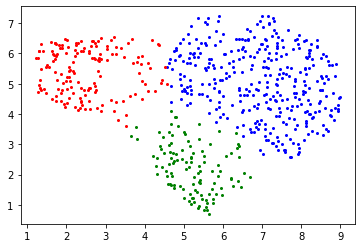

In [13]:
import json
def DataCollection(algorithm, cluster_1, cluster_2, cluster_3, results):
    
    labels = FindTrueLabels(algorithm)
    
    num1 = []
    num2 = []
    num3 = []
    
#     num1 = ClusterIndicesNumpy(0, algorithm.labels_)
#     num2 = ClusterIndicesNumpy(1, algorithm.labels_)
#     num3 = ClusterIndicesNumpy(2, algorithm.labels_) 
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    truthnum1 = {}
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        else:
            barcodes3.update({i:labels[i]})
        
        
#     for i in num1:
#         barcodes1.update({cells[i]:i})
#     for i in num2:
#         barcodes2.update({cells[i]:i})
#     for i in num3:
#         barcodes3.update({cells[i]:i})
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
        
        
    g1 = open('G1Cells.txt').readlines()
    g1_line = []
    for lines in g1:
        g1_line.append(lines)
    g2m = open('G2MCells.txt').readlines()
    g2m_line = []
    for lines in g2m:
        g2m_line.append(lines)
    s = open('SCells.txt').readlines()
    s_line = []

    res = open(results, "w")

    g1count = 0
    g2mcount = 0
    scount = 0

    g1count2 = 0
    g2mcount2 = 0
    scount2 = 0

    g1count3 = 0
    g2mcount3 = 0
    scount3 = 0
    
    
    for lines in s:
        s_line.append(lines)
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in g1_line:
            if i == j:
                g1count = g1count + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'pink'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'black'})
    print(len(truthnum1))
    res.write("G1 Count Cluster 1: \n")
    res.write(str(g1count/(len(cluster1_line))) + " \n")
    res.write(str(g1count) + " \n")
    for x in cluster1_line:
        for y in g2m_line:
            if x == y:
                g2mcount = g2mcount + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    print(len(truthnum1))
    res.write("G2M Count Cluster 1: \n")
    res.write(str(g2mcount/(len(cluster1_line))) + "\n")
    res.write(str(g2mcount) + "\n")
    for i in cluster1_line:
        for j in s_line:
            if i == j:
                scount = scount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'orange'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    print(len(truthnum1))
    res.write("S Count Cluster 1: \n")
    res.write(str(scount/(len(cluster1_line))) + "\n")
    res.write(str(scount) + "\n")
    res.write("\n")

    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in g1_line:
            if i == j:
                g1count2 = g1count2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'blue'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    print(len(truthnum1))
    res.write("G1 Count Cluster 2:" + "\n")
    res.write(str(g1count2/(len(cluster2_line))) + "\n")
    res.write(str(g1count2) + "\n")
    for i in cluster2_line:
        for j in g2m_line:
            if i == j:
                g2mcount2 = g2mcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'purple'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'black'})
    print(len(truthnum1))
    res.write("G2M Count Cluster 2:" + "\n")
    res.write(str(g2mcount2/(len(cluster2_line))) + "\n")
    res.write(str(g2mcount2) + "\n")
    for i in cluster2_line:
        for j in s_line:
            if i == j:
                scount2 = scount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    print(len(truthnum1))
    res.write("S Count Cluster 2: \n")
    res.write(str(scount2/(len(cluster2_line))) + "\n")
    res.write(str(scount2) + "\n")
    res.write("\n")

    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in g1_line:
            if i == j:
                g1count3 = g1count3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'green'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'}
    print(len(truthnum1))
        
    res.write("G1 Count Cluster 3:" + "\n")
    res.write(str(g1count3/(len(cluster3_line))) + "\n")
    res.write(str(g1count3) + "\n")
    for i in cluster3_line:
        for j in g2m_line:
            if i == j:
                g2mcount3 = g2mcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'yellow'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
    print(len(truthnum1))
    res.write("G2M Count Cluster 3:" + "\n")
    res.write(str(g2mcount3/(len(cluster3_line))) + "\n")
    res.write(str(g2mcount3) + "\n")
    for i in cluster3_line:
        for j in s_line:
            if i == j:
                scount3 = scount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'grey'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'black'})
    print(len(truthnum1))
    res.write("S Count Cluster 3:" + "\n")
    res.write(str(scount3/(len(cluster3_line))) + "\n")
    res.write(str(scount3) + "\n")
    res.write("\n")
    res.write(json.dumps(truthnum1))
    res.write("")
    print(len(true_coords))
    print(len(truthnum1))
    return truthnum1
DataCollection(spectral, 'spectral_cluster1.txt', 'spectral_cluster2.txt', 'spectral_cluster3.txt', 'spectral_results.txt')
#DataCollection(birch, 'birch_cluster1.txt', 'birch_cluster2.txt', 'birch_cluster3.txt', 'birch_results.txt')
#DataCollection(affinity_propagation,'ap_cluster1.txt', 'ap_cluster2.txt', 'ap_cluster3.txt', 'ap_results.txt')
#DataCollection(ward, 'waard_cluster1.txt', 'waard_cluster2.txt', 'waard_cluster3.txt', 'waard_results.txt')

KeyError: '[ 5.0015287 10.000468 ]'

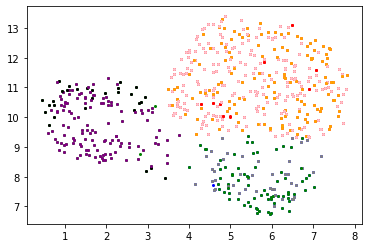

In [32]:
coloring = []
truthnum1 = DataCollection(spectral, 'spectral_cluster1.txt', 'spectral_cluster2.txt', 'spectral_cluster3.txt', 'spectral_results.txt')
for i in truthnum1:
    coloring.append(truthnum1[i])
for i in range(len(truthnum1)):
    plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=truthnum1[str(embedding[i]).strip()])
labels = ward.labels_
plt.savefig('Spectral Truth Plot.png')

KeyError: '[ 5.0015287 10.000468 ]'

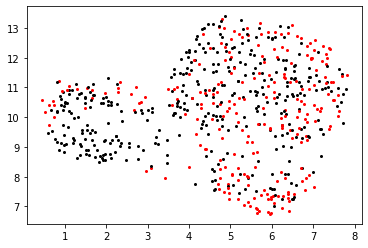

In [23]:
def DataViz(figname, algorithm, cluster1, cluster2, cluster3, results):
    coloring = []
    truthnum1 = DataCollection(algorithm, cluster1, cluster2, cluster3, results)
    for i in truthnum1:
        coloring.append(truthnum1[i])
    for i in range(len(truthnum1)):
        plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=truthnum1[str(embedding[i]).strip()])
    labels = algorithm.labels_
    plt.savefig(figname)
#DataViz("Spectral Truth Plot.png", spectral, "spectral_cluster1.txt", "spectral_cluster2.txt", "spectral_cluster3.txt", "spectral_results.txt")
#DataViz("Birch Truth Plot.png", birch, "birch_cluster1.txt", "birch_cluster2.txt", "birch_cluster3.txt", "birch_results.txt")
DataViz("Ward Truth Plot.png", ward, "ward_cluster1.txt", "ward_cluster2.txt", "ward_cluster3.txt", "ward_results.txt")